In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt
import glob
import os
import scipy.integrate as inte
import scipy.special as special
import scipy.interpolate as interp

In [3]:
import stephane.display.graphes as graphes
import stephane.tools.Smath as smath
#import sympy #symoblic python
import mpmath as math
import cv2
import glob

In [4]:
#savefolder = '/Users/stephane/Documents/Programming/Python/Notebooks/Drop_Turbulence/Uniform/'

osbase = '/media/turbots/DATA/thiou/'
#osbase = '/Volumes/'
base = osbase+'labshared2/Windveil/NedFacades/recaps/ImgsDewarp/'

num = 10
scene = 2
zone = 2

movie = 'h'+str(10)+'/scene'+str(scene)+'/'

datafolder = base+movie+'zone'+str(zone)+'/'
savefolder = base+movie+'results/'
if not os.path.isdir(savefolder):
    os.makedirs(savefolder)
    
title = 'h'+str(num)+', sc'+str(scene)+', zo'+str(zone)
print(title)

h10, sc2, zo2


In [6]:
#glob.glob(base+'h*/scene*/zone*')

In [181]:
str(title)

"['h3', 'scene3', 'zone1']"

In [7]:
imlist = glob.glob(datafolder+'*.tif')
print(len(imlist))

199


In [8]:
filename = imlist[0]

d={}
for i,filename in enumerate(imlist):
    j = int(os.path.basename(filename).split('.')[0])
    d[j] = cv2.imread(filename)
    #print(j)
#plt.imshow(im)

In [8]:
d[1].shape
print(d[1][10,10,:])

[66 66 66]


In [9]:
n = len(d.keys())
[nx,ny,nc] = d[1].shape
M = np.zeros((nx,ny,n))
for i in range(n):
    M[...,i] = d[i+1][...,0]

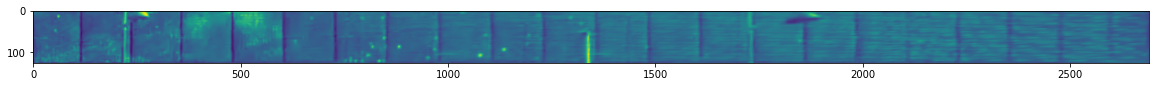

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax.imshow(M[...,0])

In [13]:
p = 12
TF = np.fft.fft(M,axis=2,n=2**p)
TF = TF[...,:2**(p-1)]

In [17]:
print(TF.shape)

(126, 2691, 2048)


/media/turbots/DATA/thiou/labshared2/Windveil/NedFacades/recaps/ImgsDewarp/h3/scene3


0.0


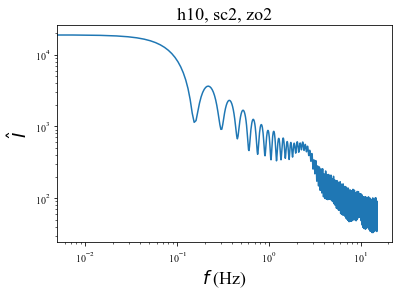

In [19]:
TF_t = np.mean(np.abs(TF),axis=(0,1))

fmax = 30/2
f = np.linspace(0,fmax,2**(p-1))
plt.plot(f,TF_t)
plt.xscale('log')
plt.yscale('log')

imax = np.argmax(TF_t)
f0  = np.round(f[imax],decimals=2)
print(f0)
#Imax = TF_t[imax]*f0
#plt.plot(f0,Imax,'rx')

figs = graphes.legende('$f$ (Hz)',r'$\hat I$',title)
graphes.save_figs(figs,savedir=savefolder,prefix=title)

(2048,)
(683,)
2.34


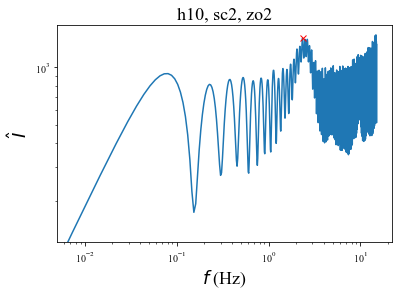

In [23]:
TF_t = np.mean(np.abs(TF),axis=(0,1))

fmax = 30/2
f = np.linspace(0,fmax,2**(p-1))
plt.plot(f,TF_t*f)
plt.xscale('log')
plt.yscale('log')
    
Z = TF_t*f
fc = 5#upper bound
Z = Z[f<fc]

print(f.shape)
print(Z.shape)
    
imax = np.argmax(Z)
f0  = np.round(f[imax],decimals=2)
print(f0)
Imax = TF_t[imax]*f0

plt.plot(f0,Imax,'rx')

figs = graphes.legende('$f$ (Hz)',r'$\hat I$',title)
graphes.save_figs(figs,savedir=savefolder,prefix=title,suffix='_compensated')

In [25]:
def demod(t,s, fexc):
    """
    Demodulate a signal at a precise frequency, 
    for instance the frequency "fexc" of a vibrating bath

    :param: 
        * t: is a temporal vector field
        * s: is a 3D (X,Y,T) signal to be demodulated 

    :return: 
        c : (X,Y) is a 2D complex field 
    """
    c = np.mean(s*np.exp(-1j * 2 * np.pi * t[None,None,:] * fexc),axis=2)
    return c

In [60]:
d={}

TypeError: data type '' not understood

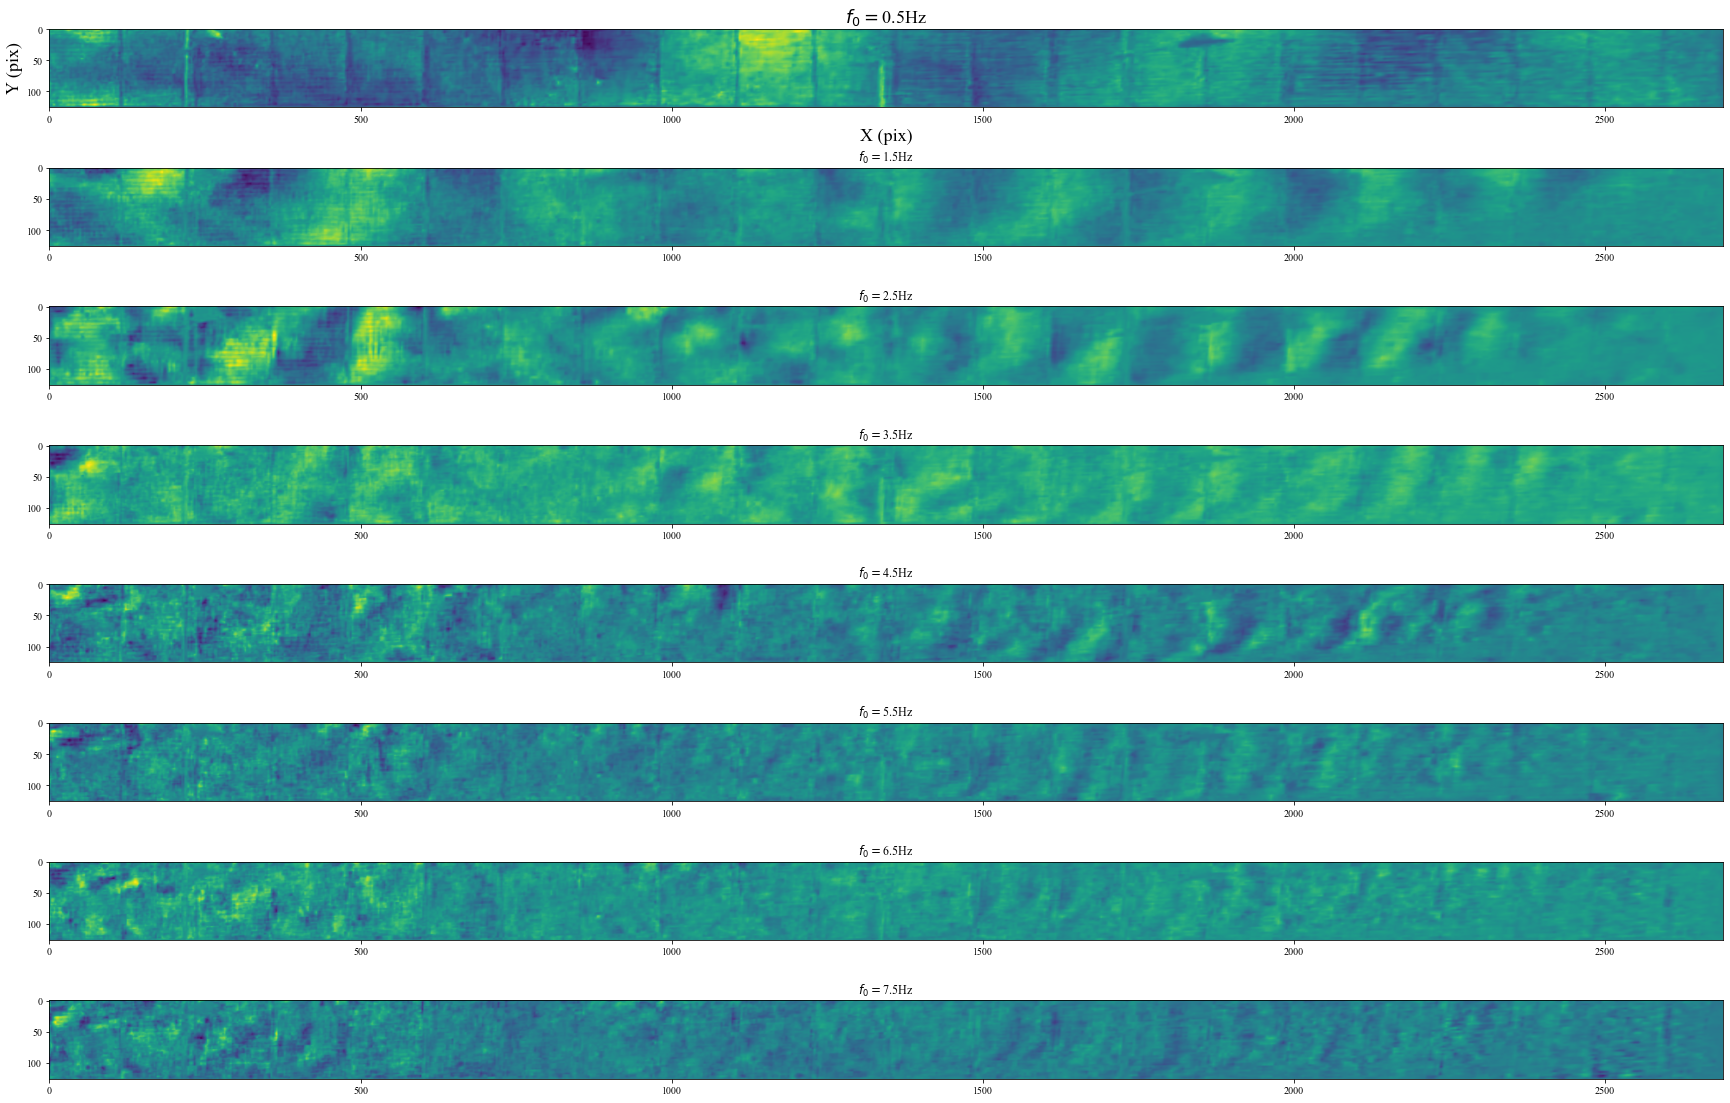

In [27]:
dt = 1/30
T = n*dt
t = np.arange(0,T,dt)
#f0 = 1.6
#d[f0] = demod(t,M,f0)

freqs = np.arange(0.5,8.5,1)
nc = len(freqs)
fig,axs = plt.subplots(nrows=nc,ncols=1,figsize=(30,20))

for i,f0 in enumerate(freqs):
    f0 = np.round(f0,decimals=2)
    d[f0] = demod(t,M,f0)
    axs[i].imshow(np.real(d[f0]))
    
    tit = '$f_0 =$'+str(f0)+'Hz'
    axs[i].set_title(tit)
    
tit = '$f_0 =$'+str(freqs[0])+'Hz'
figs = graphes.legende('X (pix)','Y (pix)',tit,ax=axs[0],cplot=True)
#graphes.save_figs(figs,savedir=savefolder)

In [29]:
print(nx,ny)
print(2**10)

126 2691
1024


In [31]:
2**12

4096

0.5
0.59
0.69
0.8
0.94
1.1
1.29
1.51
1.77
2.07
2.42
2.83
3.32
3.88
4.55
5.32
6.23
7.3
8.54
10.0


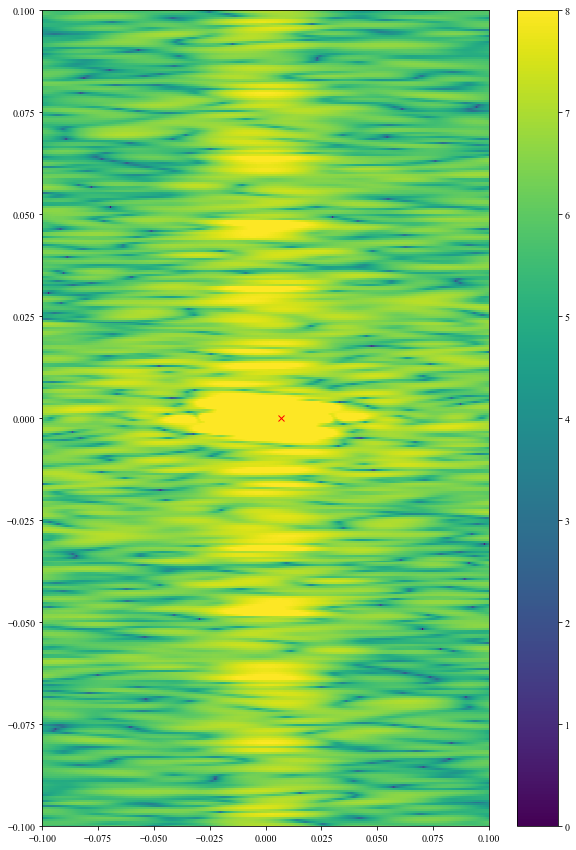

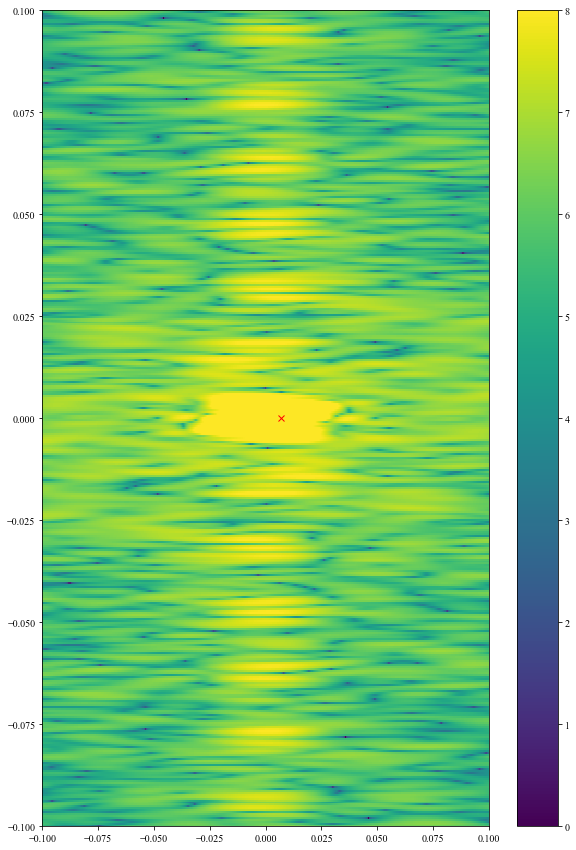

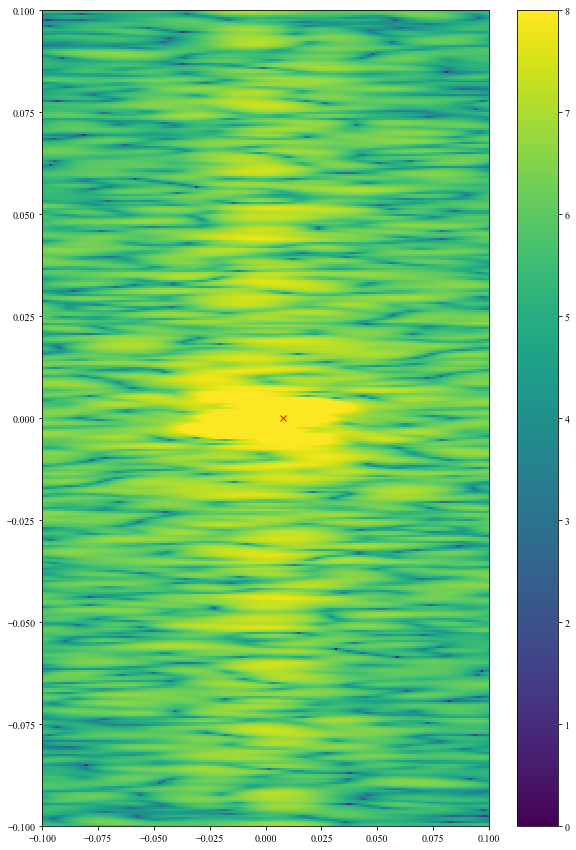

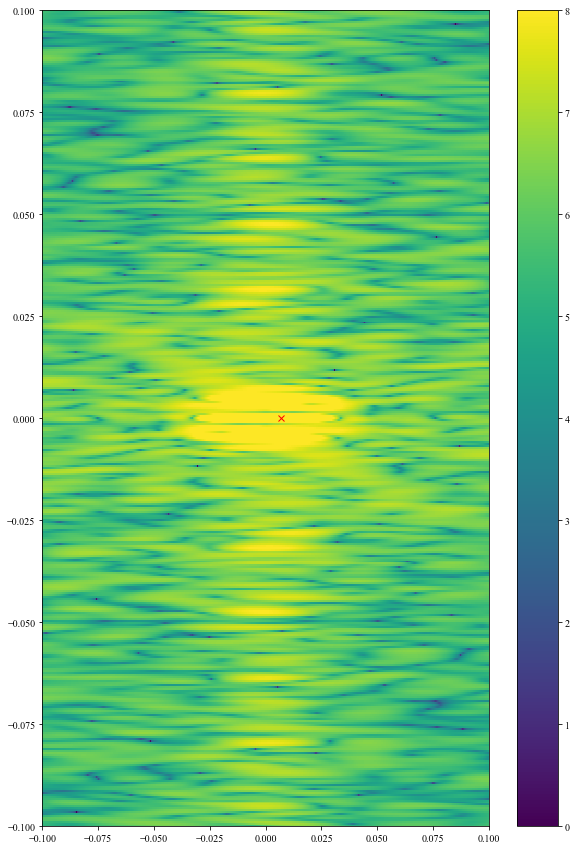

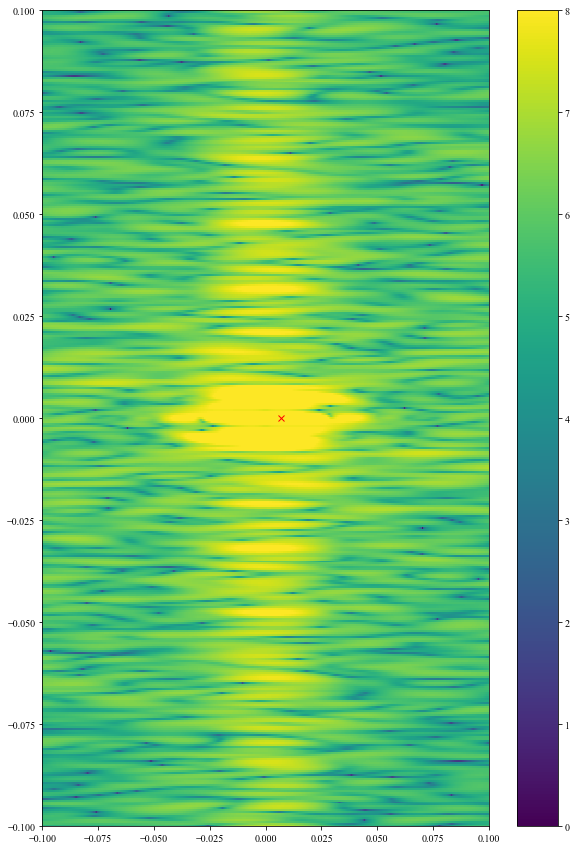

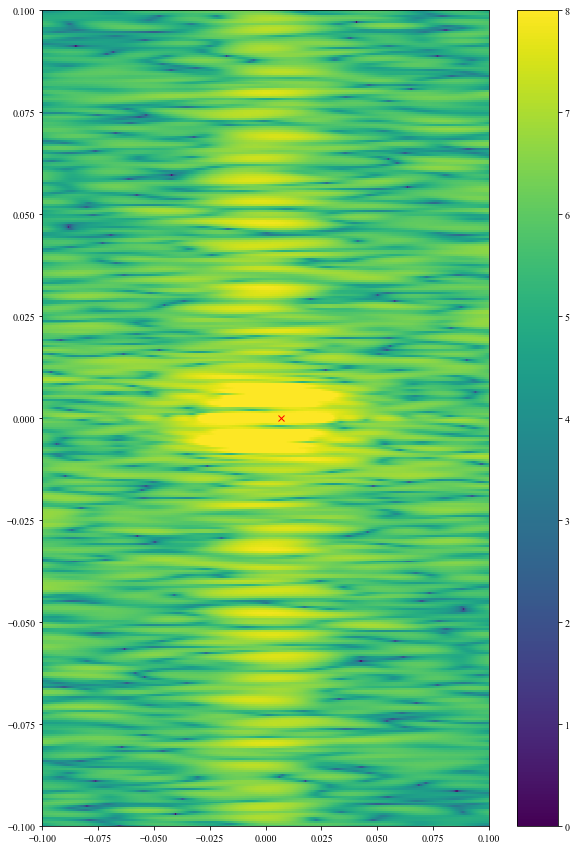

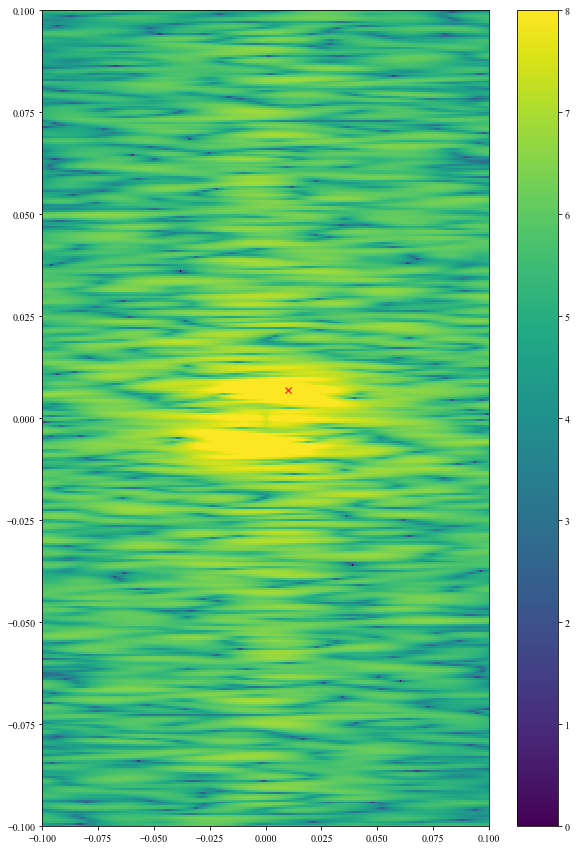

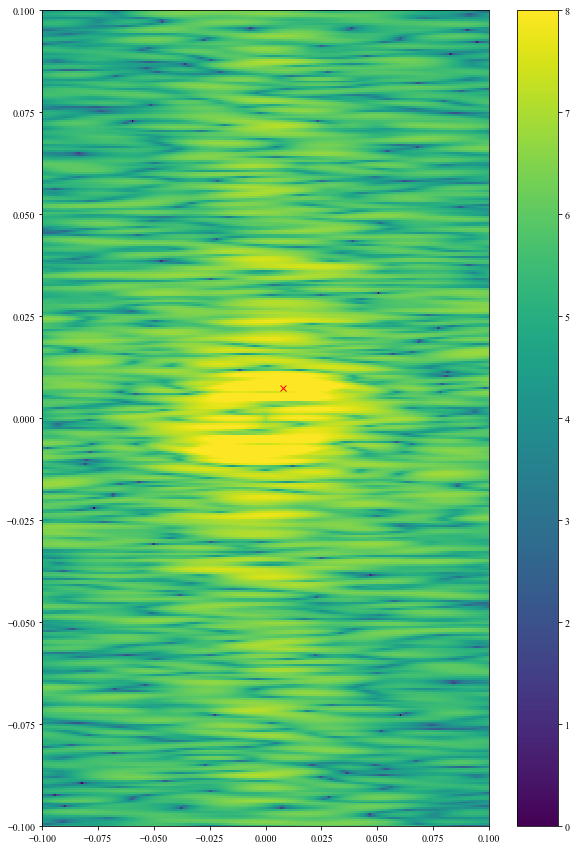

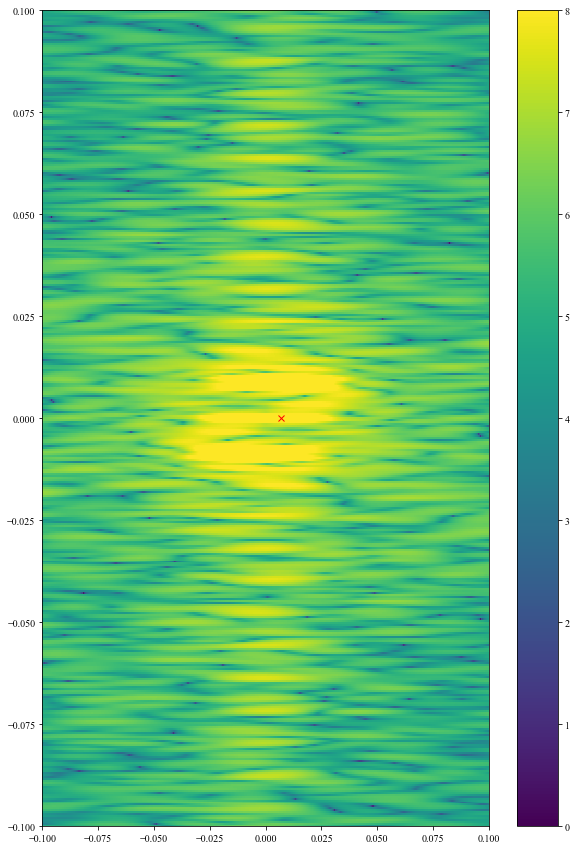

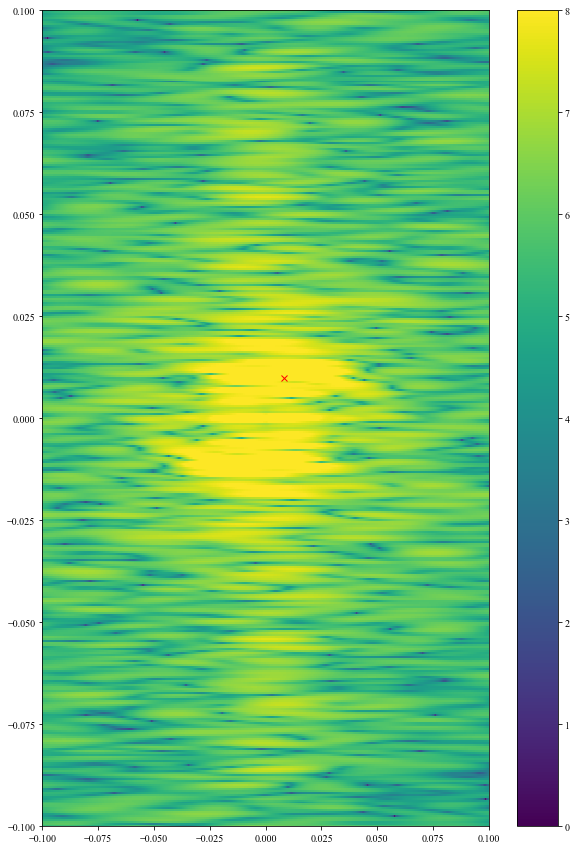

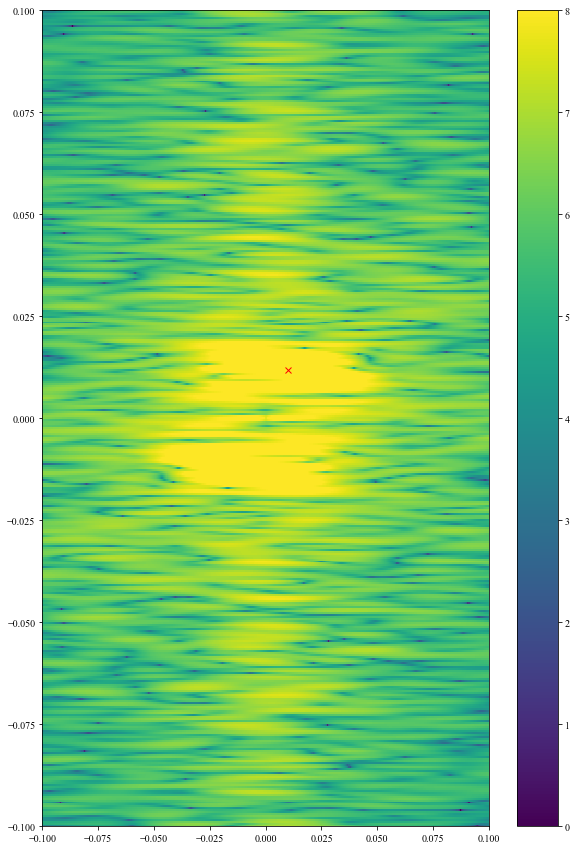

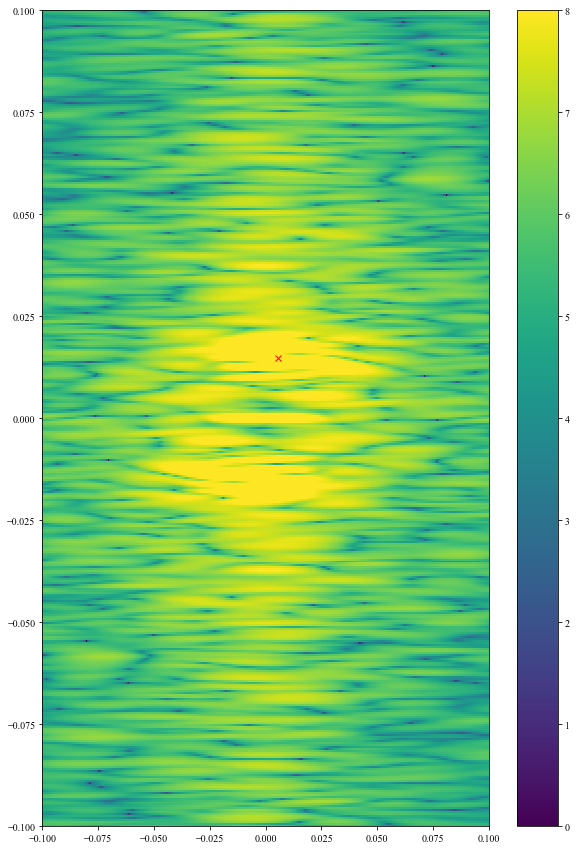

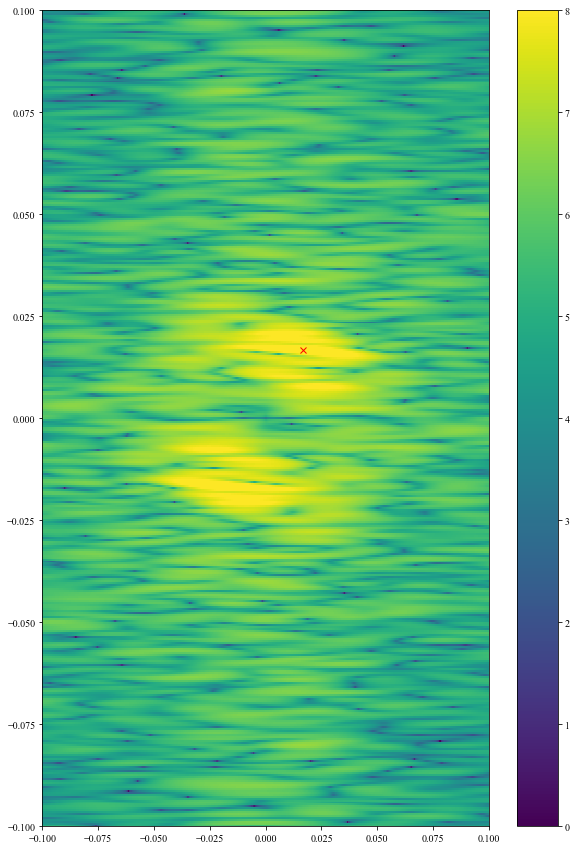

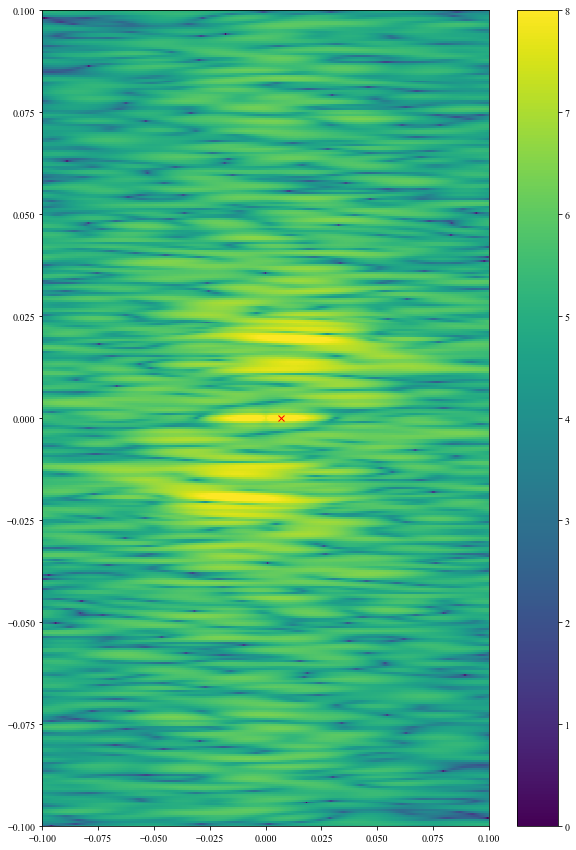

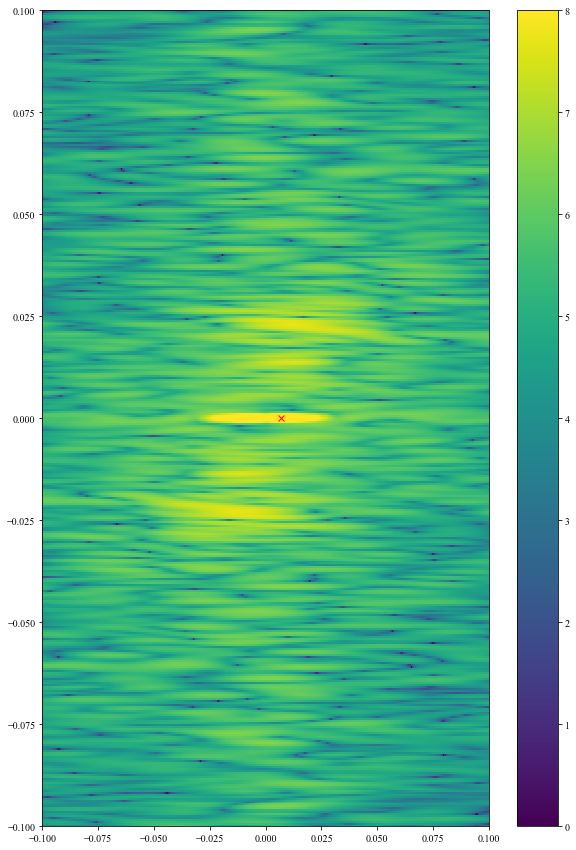

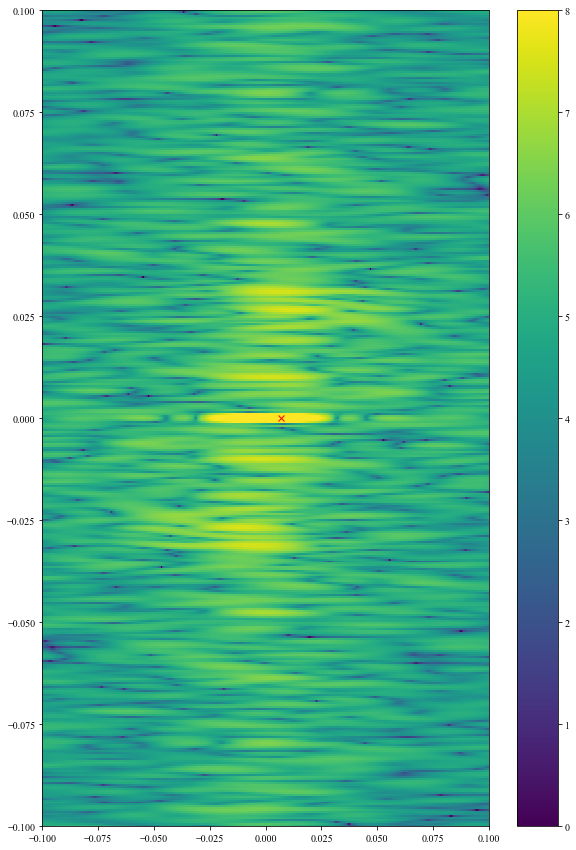

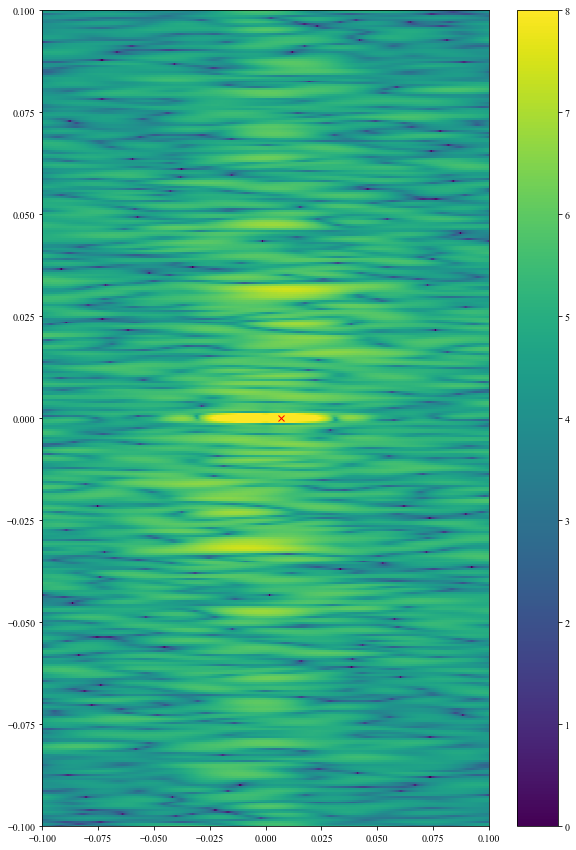

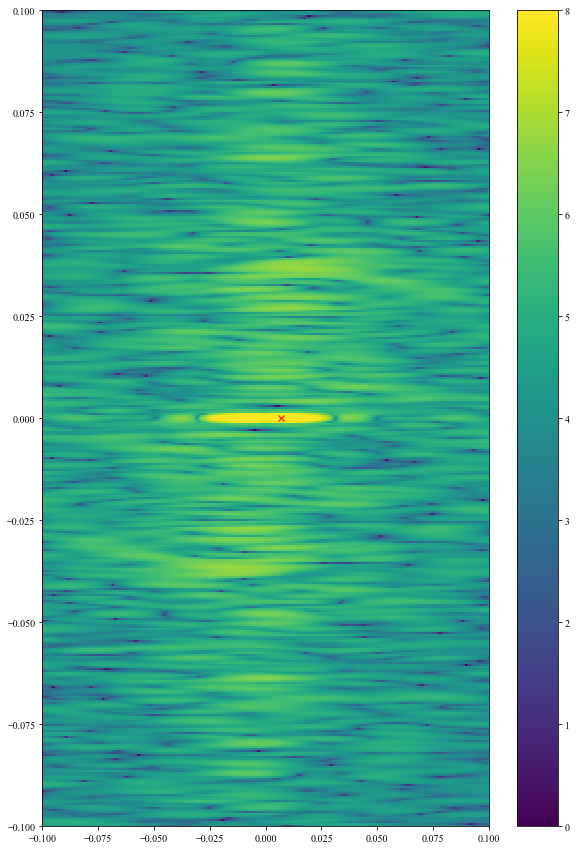

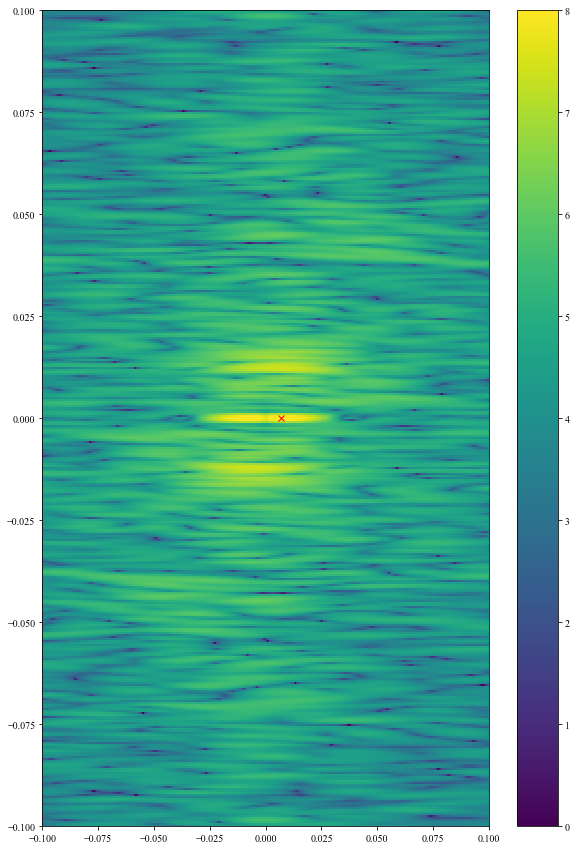

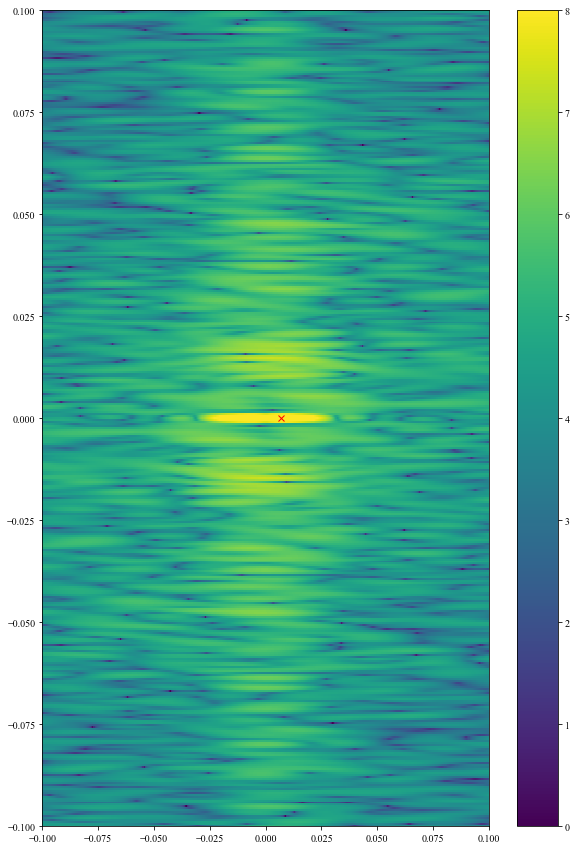

In [32]:
p0=12
freqs = np.logspace(np.log10(0.5),1,20)
kmax = 1
Res = {}
for i,f0 in enumerate(freqs):
    f0 = np.round(f0,decimals=2)
    print(f0)

    Y = np.real(demod(t,M,f0))

    nx,ny = Y.shape
    p = np.max([np.ceil(np.log2(np.max([nx,ny]))),p0])
    bx = int((2**p-nx)/2)
    by = int((2**p-ny)/2)

    wx = np.hanning(nx)
    wy = np.hanning(ny)
    W = wy[None,:]*wx[:,None]

    Y = Y*W
    
    Ypad = np.pad(Y, [(bx,bx),(by,by)], mode='constant')
    nx,ny = Ypad.shape


    #Wy,Wx = np.meshgrid(wy,wx)
    #W = np.sqrt(Wx**2+Wy**2)
    kx = np.linspace(-kmax,kmax,nx)
    ky = np.linspace(-kmax,kmax,ny)
    [Ky,Kx] = np.meshgrid(ky,kx)
    K = np.sqrt(Kx**2+Ky**2)
    
    TF_xy = np.fft.fftshift(np.fft.fft2(Ypad,s=None,norm=None))

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,15))

    Z = np.abs(TF_xy)*K**(1/4)
    
    kmin = 0
    indices = np.where(np.logical_and(np.abs(Kx)<kmin,np.abs(Ky)<kmin))
    Z[indices] = 0*Z[indices]
    
    v = np.max(Z, axis=(0,1))
    ind = np.where(Z==v)
    i = ind[0][0]
    j = ind[1][0]
    Res[f0]={}
    
    Res[f0]['K']=K[i,j]
    Res[f0]['f']=f0
    
    
#    print(Kx[i,j],Ky[i,j])
    #sc = ax.imshow(W)
    sc = ax.pcolormesh(Kx,Ky,np.log(Z),vmin=0,vmax=8)
    plt.plot(Kx[i,j],Ky[i,j],'rx')
    plt.colorbar(sc)
    #plt.axis([-0.1,0.1,-0.1,0.1])

In [205]:
p0=12
freqs = np.logspace(np.log10(0.5),1,10)
kmax = 1
Res = {}
for i,f0 in enumerate(freqs):
    f0 = np.round(f0,decimals=2)
    print(f0)

    Y = np.real(demod(t,M,f0))

    nx,ny = Y.shape
    p = np.max([np.ceil(np.log2(np.max([nx,ny]))),p0])
    bx = int((2**p-nx)/2)
    by = int((2**p-ny)/2)

    wx = np.hanning(nx)
    wy = np.hanning(ny)
    W = wy[None,:]*wx[:,None]

    Y = Y*W
    
    Ypad = np.pad(Y, [(bx,bx),(by,by)], mode='constant')
    nx,ny = Ypad.shape


    #Wy,Wx = np.meshgrid(wy,wx)
    #W = np.sqrt(Wx**2+Wy**2)
    kx = np.linspace(-kmax,kmax,nx)
    ky = np.linspace(-kmax,kmax,ny)
    [Ky,Kx] = np.meshgrid(ky,kx)
    K = np.sqrt(Kx**2+Ky**2)
    
    TF_xy = np.fft.fftshift(np.fft.fft2(Ypad,s=None,norm=None))

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,15))

    Z = np.abs(TF_xy)*K**(1/4)
    
    kmin = 0
    indices = np.where(np.logical_and(np.abs(Kx)<kmin,np.abs(Ky)<kmin))
    Z[indices] = 0*Z[indices]
    
    v = np.max(Z, axis=(0,1))
    ind = np.where(Z==v)
    i = ind[0][0]
    j = ind[1][0]
    Res[f0]={}
    
    Res[f0]['K']=K[i,j]
    Res[f0]['f']=f0
    
    
#    print(Kx[i,j],Ky[i,j])
    #sc = ax.imshow(W)
    sc = ax.pcolormesh(Kx,Ky,np.log(Z),vmin=0,vmax=8)
    plt.plot(Kx[i,j],Ky[i,j],'rx')
    plt.colorbar(sc)
    #plt.axis([-0.1,0.1,-0.1,0.1])

'/media/turbots/DATA/thiou/labshared2/Windveil/NedFacades/recaps/ImgsDewarp/h3/scene3/zone1'

In [35]:
p0=12
#Y = np.real(demod(t,M,f0))
nx,ny,nt = M.shape
print(M.shape)
p = np.max([np.ceil(np.log2(np.max([nx,ny,nt]))),p0])
bx = int((2**p-nx)/2)
by = int((2**p-ny)/2)

wx = np.ones(nx)
wy = np.hanning(ny)
wt = np.hanning(nt)
W = wy[None,None,:]*wt[None,:,None]*
Y = Y*W
    
Ypad = np.pad(Y, [(bx,bx),(by,by)], mode='constant')
nx,ny = Ypad.shape


    #Wy,Wx = np.meshgrid(wy,wx)
    #W = np.sqrt(Wx**2+Wy**2)
kx = np.linspace(-kmax,kmax,nx)
ky = np.linspace(-kmax,kmax,ny)
[Ky,Kx] = np.meshgrid(ky,kx)
K = np.sqrt(Kx**2+Ky**2)
    
#TF_xy = np.fft.fftshift(np.fft.fft2(Ypad,s=None,norm=None))

(126, 2691, 199)


ValueError: operands could not be broadcast together with shapes (126,2691) (1,2691,2691) 

figure already exists


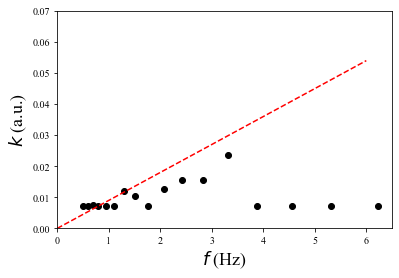

In [34]:
for f0 in Res.keys():
    plt.plot(f0,Res[f0]['K'],'ko')
    plt.axis([0,6.5,0,0.07])

a = 0.009    
fs = np.linspace(0,6,100)
plt.plot(fs,fs*a,'r--')
figs = graphes.legende('$f$ (Hz)','$k$ (a.u.)','')
graphes.save_figs(figs,savedir=savefolder,prefix=title)

In [ ]:
p=10
freqs = np.linspace(1,5,5)
kmax = 1
for i,f0 in enumerate(freqs):
    f0 = np.round(f0,decimals=2)
    print(f0)

    Y = np.real(demod(t,M,f0))

    nx,ny = Y.shape
    bx = int((2**p-nx)/2)
    by = int((2**p-ny)/2)

    wx = np.hanning(nx)
    wy = np.hanning(ny)
    W = wy[None,:]*wx[:,None]

    Y = Y*W
    
    Ypad = np.pad(Y, [(bx,bx),(by,by)], mode='constant')
    nx,ny = Ypad.shape


    #Wy,Wx = np.meshgrid(wy,wx)
    #W = np.sqrt(Wx**2+Wy**2)
    kx = np.linspace(-kmax,kmax,nx)
    ky = np.linspace(-kmax,kmax,ny)
    [Ky,Kx] = np.meshgrid(ky,kx)

    TF_xy = np.fft.fftshift(np.fft.fft2(Ypad,s=None,norm=None))

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,15))

    #sc = ax.imshow(W)
    sc = ax.pcolormesh(Kx,Ky,np.log(np.abs(TF_xy)),vmin=0,vmax=8)
    plt.colorbar(sc)

In [ ]:
dt = 1/30
T = n*dt
t = np.arange(0,T,dt)
#f0 = 1.6
#d[f0] = demod(t,M,f0)

freqs = np.arange(1.4,3,0.2)
nc = len(freqs)
fig,axs = plt.subplots(nrows=1,ncols=nc,figsize=(30,20))

for i,f0 in enumerate(freqs):
    f0 = np.round(f0,decimals=2)
    d[f0] = demod(t,M,f0)
    axs[i].imshow(np.real(d[f0]))
    
    tit = '$f_0 =$'+str(f0)+'Hz'
    axs[i].set_title(tit)
    
tit = '$f_0 =$'+str(freqs[0])+'Hz'
figs = graphes.legende('X (pix)','Y (pix)',tit,ax=axs[0],cplot=True)
graphes.save_figs(figs,savedir=savefolder)

In [6]:
I={}
for filename in filelist[:3]:
    I={}
    I['fx'] = fx
    if U0==0:
        x,y = [32,383]
    else:
        x,y = [32,380]
    I[U0]['x0'] = x
    I[U0]['y0'] = y
    
# Output img with window name as 'image'
    plt.figure(figsize=(15,15))
    plt.imshow(I[U0]['im'])

In [8]:
keylist = [0,20,40,60]
for key in keylist:#key = 20
    if key ==0:
        filelist = glob.glob(datafolder+'00Hz*min.txt')
    else:
        filelist = glob.glob(datafolder+str(key)+'Hz*min.txt')
    data[key]={}
    for f in filelist:
        d = np.loadtxt(f,delimiter=',')
        if '_near_' in f:
            data[key]['near']=d
        if '_far_' in f:
            data[key]['far']=d
            

#print(filelist[1])
#print(data.shape)

In [40]:
for key in data.keys():
    xc,yc = 639,1750
    data[key]['x0']=xc
    data[key]['y0']=yc

In [21]:
fu = 1/9

4096 2304


0.8925

0.37481259370314846

0.7256089704383283

In [145]:
v0*(1-eps)

4.050000000000001

0.0025484199796126407

In [55]:
0.714*2

1.428

In [147]:
fx = 0.132

In [162]:
data[key][k].shape

(2304, 4096)

NameError: name 'data' is not defined

In [46]:
50*85/93

45.69892473118279

In [258]:
yc

380

In [43]:
I.keys()

dict_keys([0.0, 2.38, 6.67])

In [45]:
I[0.0].keys()

dict_keys(['im', 'fx', 'x0', 'y0'])

SyntaxError: invalid syntax (<ipython-input-16-75a54d03c61a>, line 2)

In [105]:
display = False

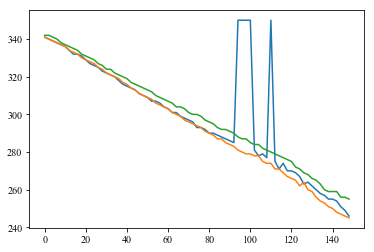

In [312]:
alist

array([0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64])

In [300]:
data[a][key].keys()

dict_keys(['yM', 'ym', 'x', 'p'])

In [308]:
data.keys()

dict_keys([0.5, 'yM', 'ym', 'x', 0.12, 0.13, 0.14, 0.15000000000000002, 0.16000000000000003, 0.17000000000000004, 0.18000000000000005, 0.19000000000000006, 0.20000000000000007, 0.21000000000000008, 0.22000000000000008, 0.2300000000000001, 0.2400000000000001, 0.2500000000000001, 0.2600000000000001, 0.27000000000000013, 0.28000000000000014, 0.29000000000000015, 0.30000000000000016, 0.31000000000000016, 0.3200000000000002, 0.3300000000000002, 0.3400000000000002, 0.3500000000000002, 0.3600000000000002, 0.3700000000000002, 0.3800000000000002, 0.39000000000000024, 0.40000000000000024, 0.41000000000000025, 0.42000000000000026, 0.43000000000000027, 0.4400000000000003, 0.4500000000000003, 0.4600000000000003, 0.4700000000000003, 0.4800000000000003, 0.4900000000000003, 0.5000000000000003, 0.5100000000000003, 0.5200000000000004, 0.5300000000000004, 0.5400000000000004, 0.5500000000000004, 0.5600000000000004, 0.5700000000000004, 0.5800000000000004, 0.5900000000000004, 0.6000000000000004, 0.610000000

In [311]:
data[0.5][2.38].keys()#['p'][0]

dict_keys(['yM', 'ym', 'x'])

In [ ]:
np.polyval

In [292]:
alist

array([0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64])

0.6400000000000005


KeyError: 'p'

[-9.37087190e-04  7.10064638e-01  1.78231397e+02]
[-6.18692907e-04  6.13055554e-01  1.78286365e+02]


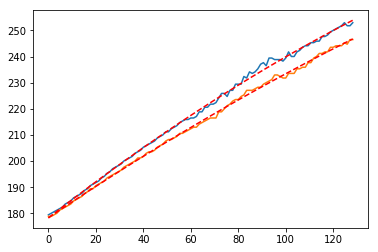

In [57]:
Iref

44.41493055555556

In [30]:
data = {}

In [68]:
Xlist.shape

(100,)

In [103]:
for key in data.keys():
    data[key] = np.asarray(data[key])

In [101]:
Fr0

8.567058737562386

In [227]:
theta

1.1780972450961724

In [47]:
data=[]

0
1
2
3
4
5
6
7
8
9


[[1.         0.41989512]
 [0.41989512 1.        ]]
[[1.         0.50450887]
 [0.50450887 1.        ]]
[[1.         0.20256444]
 [0.20256444 1.        ]]


In [ ]:
#correlation time ?